In [108]:
import os
import argparse

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.metrics import confusion_matrix
import seaborn as sn

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.autograd import Variable
from torchvision.utils import save_image

In [109]:
import mobilenetv3
model = mobilenetv3.mobilenetv3_large()
test_data = "nist_test_data/"
pth = "train_results2_mv3/own_data_fingermodel_mv3_bal_0.0001_50.pth"

In [110]:
device = torch.device("cuda" if torch.cuda.is_available() 
                                  else "cpu")
model = mobilenetv3.mobilenetv3_large()

model.to(device)
model.load_state_dict(torch.load(pth, map_location=device))
model.eval()

MobileNetV3(
  (features): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): h_swish(
        (sigmoid): h_sigmoid(
          (relu): ReLU6(inplace=True)
        )
      )
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Identity()
        (4): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e

In [111]:
test_transforms = transforms.Compose([transforms.Resize([224,224]),transforms.ToTensor(),transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
data = datasets.ImageFolder(test_data, transform = test_transforms)
classes = data.classes
print(classes, "cls")
loader = torch.utils.data.DataLoader(data, batch_size=1)

['distal', 'non_distal'] cls


In [112]:
def predict_image(image):
    image_tensor = image
    image_tensor = image_tensor.to(device)
    output = model(image_tensor)
    index = output.data.cpu().numpy().argmax(axis=1)
    return index

In [113]:
import time
begin = time.time()
index_list = []
indexes_list=[]
labels_list = []
count=0
counter=[]
output=[]
c=0
for ii,(images,labels) in enumerate(loader):
    labels_list.append(labels)
    index= predict_image(images)
    ls = index[0]
    index_list.append(index)
    indexes_list.append(ls)
    #print(index[0])
    #print(labels.cpu().numpy()[0], "lab")
    res = labels.cpu().numpy()[0] == index[0]
    #print(labels[0])
    #save_image(images, os.path.join(results_dir,'image_'+str(ii)+'_'+str(classes[index[0]])+'_'+str(res)+'.png'))
    #print(res)
    if res:
        c = c+1

    count+=1
    counter.append(count)
end = time.time()
print(end-begin)

124.12042903900146


In [114]:
indices = np.concatenate(index_list, axis = 0)
labels = torch.cat(labels_list, dim = 0).cpu().numpy().astype(np.int32)
accuracy = (indices == labels).sum()/labels.shape[0]*100

print("The accuracy is ", accuracy)

The accuracy is  93.502658003544


In [78]:
array = confusion_matrix(labels_list, index_list)
print(array)

[[1487  171]
 [  49 1679]]


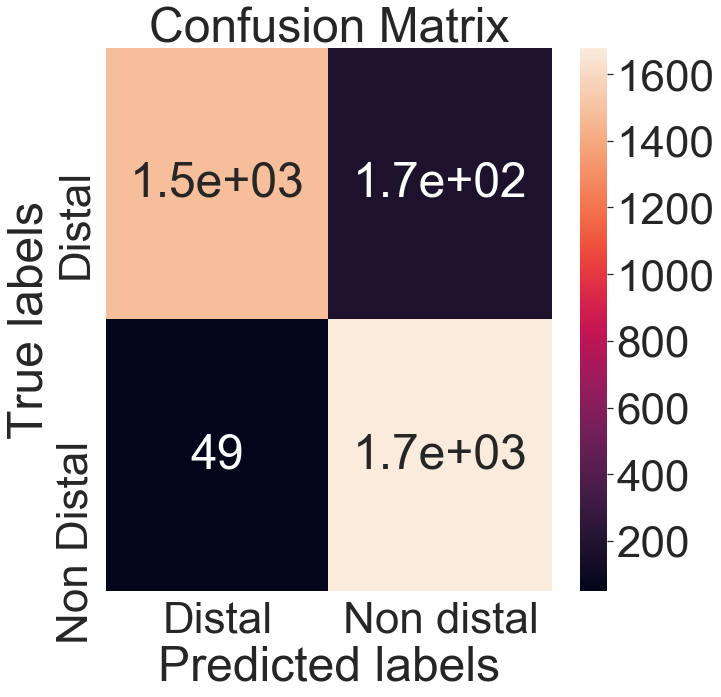

In [79]:
plt.figure(figsize=(10,10))
ax= plt.subplot()
sn.set(font_scale=4.0)
sn.heatmap(array, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Distal', 'Non distal']); ax.yaxis.set_ticklabels(['Distal', 'Non Distal'])
plt.show()